In [1]:
%matplotlib inline

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import numpy
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn
import rioxarray
import rasterstats as rs

/Users/delatorredm/miniconda3/envs/ee/lib/python3.8/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/delatorredm/miniconda3/envs/ee/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
!pwd

/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts


In [12]:
#evi = rioxarray.open_rasterio('eviPredictand_WS_ORIG.tiff')
#variates = rioxarray.open_rasterio('modelPredictors_WS_ORIG.tiff')
#points_wet_irr = geopandas.read_file('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/sampling_points/sp_irrigated.shp')#dry_rf wet_rf wet_irr wet_rf
points_wet_irr = geopandas.read_file('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/sampling_points/sp_hi_corr_rainfed.shp')
#points_wet_irr = geopandas.read_file('points_wet_irr.shp')#dry_rf wet_rf wet_irr wet_rf
evids_path = 'work/eviTS_v03_17year.tif'
modelPredictors_path = 'work/modelPredictors_v03_17year.tif'

# Extract zonal stats
evi_stats = rs.zonal_stats(points_wet_irr, evids_path, stats = 'mean') #WS or DS

# View object type
#type(evi_stats)

# Extract zonal stats (takes some time)
# WS OR DS
pcp_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 1, stats = 'mean')
lstday_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 2 , stats = 'mean')
lstnight_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 3, stats = 'mean')
et_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 4, stats = 'mean')
pet_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 5, stats = 'mean')
ele_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 6, stats = 'mean')
slp_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 7, stats = 'mean')


# View object type
#type(pcp_stats)
#type(lstday_stats)
#type(lstnight_stats)

# Organize into dataframes
evi_pd = pd.DataFrame(evi_stats).rename(columns={'mean':'evi'})
pcp_pd = pd.DataFrame(pcp_stats).rename(columns={'mean':'pcp'})
lstday = pd.DataFrame(lstday_stats).rename(columns={'mean':'lstday'})
lstnight = pd.DataFrame(lstnight_stats).rename(columns={'mean':'lstnight'})
et = pd.DataFrame(et_stats).rename(columns={'mean':'et'})
pet = pd.DataFrame(pet_stats).rename(columns={'mean':'pet'})
ele = pd.DataFrame(ele_stats).rename(columns={'mean':'elevation'})
slp = pd.DataFrame(slp_stats).rename(columns={'mean':'slope'})

# Concatenate
df = pd.concat([evi_pd, pcp_pd, lstday, lstnight, et, pet, ele, slp], axis=1)
#df = pd.concat([evi_pd, pcp_pd, lstday, lstnight], axis=1)
df.tail()

/Users/delatorredm/miniconda3/envs/ee/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,evi,pcp,lstday,lstnight,et,pet,elevation,slope
36,0.500009,239.724319,30.043825,21.722713,40.620178,75.326141,169.0,2.038945
37,0.507590,235.953171,29.328936,22.027508,53.380089,99.162231,37.0,8.552918
38,0.520218,210.226318,28.188076,24.074291,80.832153,121.380447,20.0,2.136595
39,0.504202,230.278549,30.063023,22.201294,44.836765,84.027016,79.0,4.304339
40,0.471048,229.680023,29.898579,22.226061,47.019318,87.549110,44.0,2.167169


In [5]:
# Alternative Variables
df['log_evi']=numpy.log(df['evi'])
df['exp_evi']=numpy.exp(df['evi'])
df['ratioday']=df['pcp']/df['lstday']
df['ratioday1']=df['lstday']/df['pcp']
df['rationight']=df['pcp']/df['lstnight']
df['rationight1']=df['lstnight']/df['pcp']
df['lstdiff']=df['lstday']-df['lstnight']
df['lstdiff1']=df['et']/(df['lstday']-df['lstnight'])
df['water_deficit']=df['et']-(df['pcp'])
df['water_deficit1']=numpy.log(df['et']-(df['pcp']))
#df['water_deficit2']=numpy.exp(df['pcp'])


In [21]:
import numpy as np

results = sm.ols(formula = "evi ~ elevation", 
                 missing='drop',
                 data=df).fit()
print(results.summary())
#print(results.pvalues)

                            OLS Regression Results                            
Dep. Variable:                    evi   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     9.797
Date:                Thu, 04 Nov 2021   Prob (F-statistic):            0.00330
Time:                        15:19:30   Log-Likelihood:                 82.584
No. Observations:                  41   AIC:                            -161.2
Df Residuals:                      39   BIC:                            -157.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4535      0.009     50.917      0.0

# DRY SEASON

In [468]:
#evi = rioxarray.open_rasterio('eviPredictand_WS_ORIG.tiff')
#variates = rioxarray.open_rasterio('modelPredictors_WS_ORIG.tiff')
#points_wet_irr = geopandas.read_file('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/sampling_points/sp_irrigated.shp')#dry_rf wet_rf wet_irr wet_rf
#points_wet_irr = geopandas.read_file('points_dry_irr.shp')#dry_rf wet_rf wet_irr wet_rf
points_wet_irr = geopandas.read_file('/Users/delatorredm/OneDrive - The University of Auckland/Ch4_Climate_Impacts/sampling_points/sp_hi_corr_irrigated.shp')
evids_path = 'eviPredictand_DS_V01.tiff'
modelPredictors_path = 'modelPredictors_DS_V02.tiff'

# Extract zonal stats
evi_stats = rs.zonal_stats(points_wet_irr, evids_path, stats = 'mean') #WS or DS

# View object type
#type(evi_stats)

# Extract zonal stats (takes some time)
# WS OR DS
pcp_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 1, stats = 'mean')
lstday_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 2 , stats = 'mean')
lstnight_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 3, stats = 'mean')
et_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 4, stats = 'mean')
pet_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 5, stats = 'mean')
ele_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 6, stats = 'mean')
slp_stats = rs.zonal_stats(points_wet_irr, modelPredictors_path, band_num = 7, stats = 'mean')


# View object type
#type(pcp_stats)
#type(lstday_stats)
#type(lstnight_stats)

# Organize into dataframes
evi_pd = pd.DataFrame(evi_stats).rename(columns={'mean':'evi'})
pcp_pd = pd.DataFrame(pcp_stats).rename(columns={'mean':'pcp'})
lstday = pd.DataFrame(lstday_stats).rename(columns={'mean':'lstday'})
lstnight = pd.DataFrame(lstnight_stats).rename(columns={'mean':'lstnight'})
et = pd.DataFrame(et_stats).rename(columns={'mean':'et'})
pet = pd.DataFrame(pet_stats).rename(columns={'mean':'pet'})
ele = pd.DataFrame(ele_stats).rename(columns={'mean':'elevation'})
slp = pd.DataFrame(slp_stats).rename(columns={'mean':'slope'})

# Concatenate
df = pd.concat([evi_pd, pcp_pd, lstday, lstnight, et, pet, ele, slp], axis=1)
#df = pd.concat([evi_pd, pcp_pd, lstday, lstnight], axis=1)
df.tail()

/Users/delatorredm/miniconda3/envs/ee/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,evi,pcp,lstday,lstnight,et,pet,elevation,slope
32,0.419098,88.575729,31.853825,22.191895,44.796944,91.997314,19.0,0.331031
33,0.402252,84.086655,31.665157,22.406481,62.308887,116.933243,3.0,0.165506
34,0.483666,88.445236,32.976761,22.201859,39.300465,89.063057,28.0,0.165521
35,0.436326,99.701157,31.391125,22.235571,41.074814,87.395279,26.0,0.590651
36,0.348275,84.086655,31.768293,22.748943,46.774723,103.059998,6.0,0.372803


In [469]:
# Alternative Variables
df['log_evi']=numpy.log(df['evi'])
df['exp_evi']=numpy.exp(df['evi'])
df['ratioday']=df['pcp']/df['lstday']
df['ratioday1']=df['lstday']/df['pcp']
df['rationight']=df['pcp']/df['lstnight']
df['rationight1']=df['lstnight']/df['pcp']
df['lstdiff']=df['lstday']-df['lstnight']
df['lstdiff1']=df['et']/(df['lstday']-df['lstnight'])
df['water_deficit']=df['et']-(df['pcp'])
df['water_deficit1']=numpy.log(df['et']-(df['pcp']))
#df['water_deficit2']=numpy.exp(df['pcp'])


In [470]:
df.tail()

,evi,pcp,lstday,lstnight,et,pet,elevation,slope,log_evi,exp_evi,ratioday,ratioday1,rationight,rationight1,lstdiff,lstdiff1,water_deficit,water_deficit1
32,0.419098,88.575729,31.853825,22.191895,44.796944,91.997314,19.0,0.331031,-0.869651,1.520589,2.780694,0.359622,3.991355,0.250541,9.661930,4.636438,-43.778786,NaN
33,0.402252,84.086655,31.665157,22.406481,62.308887,116.933243,3.0,0.165506,-0.910676,1.495188,2.655495,0.376578,3.752783,0.266469,9.258677,6.729783,-21.777767,NaN
34,0.483666,88.445236,32.976761,22.201859,39.300465,89.063057,28.0,0.165521,-0.726362,1.622009,2.682047,0.372849,3.983686,0.251024,10.774902,3.647408,-49.144772,NaN
35,0.436326,99.701157,31.391125,22.235571,41.074814,87.395279,26.0,0.590651,-0.829367,1.547012,3.176094,0.314852,4.483859,0.223022,9.155554,4.486328,-58.626343,NaN
36,0.348275,84.086655,31.768293,22.748943,46.774723,103.059998,6.0,0.372803,-1.054762,1.416622,2.646874,0.377804,3.696288,0.270542,9.019350,5.186041,-37.311932,NaN


In [489]:
import numpy as np

results = sm.ols(formula = "evi ~ pcp + lstnight + pet + elevation", 
                 missing='drop',
                 data=df).fit()
print(results.summary())
#print(results.pvalues)

                            OLS Regression Results                            
Dep. Variable:                    evi   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     7.451
Date:                Wed, 01 Sep 2021   Prob (F-statistic):           0.000233
Time:                        16:48:39   Log-Likelihood:                 77.621
No. Observations:                  37   AIC:                            -145.2
Df Residuals:                      32   BIC:                            -137.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6021      0.598      6.026      0.0

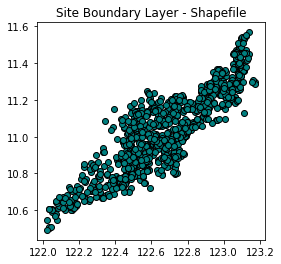

In [44]:
# Plot the vector data
f, ax = plt.subplots(figsize=(8,4))
points_wet_irr.plot(color='teal',
                    edgecolor='black',
                    ax=ax)
ax.set(title="Site Boundary Layer - Shapefile")
plt.show()


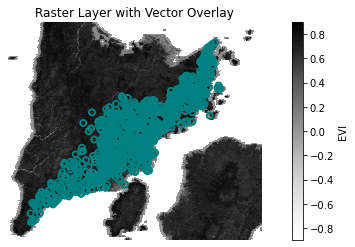

In [45]:
f, ax = plt.subplots(figsize=(11, 4))

evi.squeeze().plot.imshow(cmap="Greys",
                        ax=ax)
points_wet_irr.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax,
                    zorder=4)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
plt.show()


In [54]:
results = sm.glm(formula = "evi ~ pcp + lstday + lstnight + et + pet", 
                 data=df, missing='drop').fit()
print(results.summary())
print(results.pvalues
     )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    evi   No. Observations:                  967
Model:                            GLM   Df Residuals:                      961
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                       0.0015896
Method:                          IRLS   Log-Likelihood:                 1746.7
Date:                Mon, 16 Aug 2021   Deviance:                       1.5276
Time:                        19:46:16   Pearson chi2:                     1.53
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9297      0.073     12.788      0.0

In [40]:
results = sm.logit(formula = "evi ~ pcp + pet", 
                 data=df, missing='drop').fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.654075
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    evi   No. Observations:                  987
Model:                          Logit   Df Residuals:                      984
Method:                           MLE   Df Model:                            2
Date:                Thu, 19 Aug 2021   Pseudo R-squ.:                  -4.145
Time:                        16:38:39   Log-Likelihood:                -645.57
converged:                       True   LL-Null:                       -125.48
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0297      1.178      0.025      0.980      -2.280       2.339
pcp            0.0005      0.